In [2]:
import pandas as pd
import glob
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
from skimage.draw import polygon2mask
import tifffile
from skimage import color
from skimage import img_as_ubyte

In [3]:
def read_results(path_pattern, metadata_path):
    meta = pd.read_csv(metadata_path, sep='\t')
    
    dsets = []
    for path in glob.glob('results_analysis_Threshold_15/*/vf.csv'):
        directory = os.path.dirname(path)
        print(directory)
        parts = directory.split(os.sep)
        sample = parts[1]
        #stain = parts[2]

        data = pd.read_csv(path)
        data['sample'] = sample
        #data['stain'] = stain
        data['genotype'] = meta[meta['Animal'] == int(sample)]['Genotype'].values[0]
        dsets.append(data)

    all_data = pd.concat(dsets, ignore_index=True)
    all_data['vm'] = np.abs(np.sqrt(all_data['vx']**2 + all_data['vy']**2))
    return all_data

def get_animal_genotype(animal, metadata_path='metadataALL.txt'):
    meta = pd.read_csv(metadata_path, sep='\t')
    return meta[meta['Animal'] == int(animal)]['Genotype'].values[0]
    
def poly_area(x, y):
    # https://stackoverflow.com/a/30408825
    return 0.5*np.abs(np.dot(x,np.roll(y,1))-np.dot(y,np.roll(x,1)))

def poly_to_mask(x, y, shape, scale=1):
    x = x / scale
    y = y / scale
    msk = polygon2mask((shape[1], shape[0]), np.swapaxes(np.array([x, y]), 0, 1))
    msk = np.flipud(np.rot90(msk))
    return msk


def load_images(sample, t=None):
    base_dir = r'/Users/garvitgupta/Downloads/front-tracking-main/data_all'
    image_paths = sorted(glob.glob(os.path.join(base_dir, sample, 'processed', '*.tif')))
    
    if t is None:
        images = []
        for p in image_paths:
            images.append(__load_img(p))
        return np.array(images)
    else:
        p = image_paths[t]
        return __load_img(p)

__imcache = {}
def __load_img(path):
    if path not in __imcache:
        im = tifffile.imread(path)
        im = color.rgb2gray(im)
        im = np.asarray(img_as_ubyte(im))
        __imcache[path] = im
    
    return __imcache[path]

__scalecache = {}
def read_scale(sample):
    key = (sample)
    if key not in __scalecache:
        base_dir = r'/Users/garvitgupta/Downloads/front-tracking-main/data_all'
        meta_path = os.path.join(base_dir, sample, '*.tif')
        first = glob.glob(meta_path)[0]
        first_meta = os.path.join(base_dir, sample, '.Metadata', '{}.cal.xml'.format(os.path.basename(first)))

        ns = 'http://schemas.datacontract.org/2004/07/LeicaMicrosystems.DataEntities.V3_2'
        tree = ET.parse(first_meta)
        root = tree.getroot()
        res = tree.find(".//{"+ns+"}XMetresPerPixel").text
        
        __scalecache[key] = float(res) * 1e3
    return __scalecache[key]
    

In [3]:
doc = read_scale('10')
print(doc)

0.010246190744920992


In [4]:
all_data = read_results('results_analysis_Threshold_10/*/vf.csv', 'metadataALL.txt')
all_data

results_analysis_Threshold_15/132
results_analysis_Threshold_15/9
results_analysis_Threshold_15/118
results_analysis_Threshold_15/127
results_analysis_Threshold_15/10
results_analysis_Threshold_15/75
results_analysis_Threshold_15/126
results_analysis_Threshold_15/88
results_analysis_Threshold_15/31
results_analysis_Threshold_15/79
results_analysis_Threshold_15/83
results_analysis_Threshold_15/77
results_analysis_Threshold_15/84
results_analysis_Threshold_15/12
results_analysis_Threshold_15/76
results_analysis_Threshold_15/47


,t,fi,x,y,vx,vy,wx,wy,th,sample,genotype,vm
0,120,1,3.456283,9.471009,-0.000871,-0.000062,-0.000871,-0.000062,NaN,132,WT,0.000873
1,120,1,3.456763,9.464273,NaN,NaN,NaN,NaN,NaN,132,WT,NaN
2,120,1,3.457236,9.457386,NaN,NaN,NaN,NaN,NaN,132,WT,NaN
3,120,1,3.457699,9.450360,-0.000792,-0.000052,-0.000792,-0.000052,NaN,132,WT,0.000793
4,120,1,3.458167,9.443214,NaN,NaN,NaN,NaN,NaN,132,WT,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
6179411,3600,707,13.729794,9.671696,NaN,NaN,NaN,NaN,NaN,47,WT,NaN
6179412,3600,707,13.729646,9.668357,NaN,NaN,NaN,NaN,NaN,47,WT,NaN
6179413,3600,707,13.729612,9.664538,NaN,NaN,NaN,NaN,NaN,47,WT,NaN
6179414,3600,707,13.729692,9.660258,NaN,NaN,NaN,NaN,NaN,47,WT,NaN


In [8]:
vm = all_data.groupby(['sample', 't', 'fi']).aggregate({'vm': np.nanmean}).reset_index().dropna(subset=['vm'])
vm

,sample,t,fi,vm
0,10,360,1,0.003214
1,10,360,2,0.002758
2,10,360,3,0.003519
3,10,420,4,0.002226
5,10,420,6,0.002415
...,...,...,...,...
12769,9,3600,469,0.002923
12770,9,3600,470,0.000126
12772,9,3600,472,0.000168
12775,9,3600,475,0.000428


<AxesSubplot:xlabel='t', ylabel='vm'>

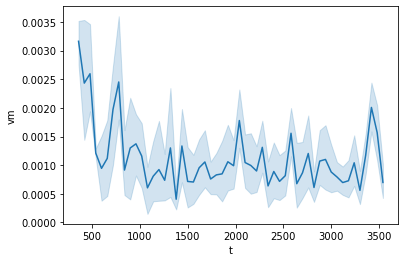

In [6]:
sns.lineplot(data=vm[vm['sample']=='10'], x='t', y='vm')

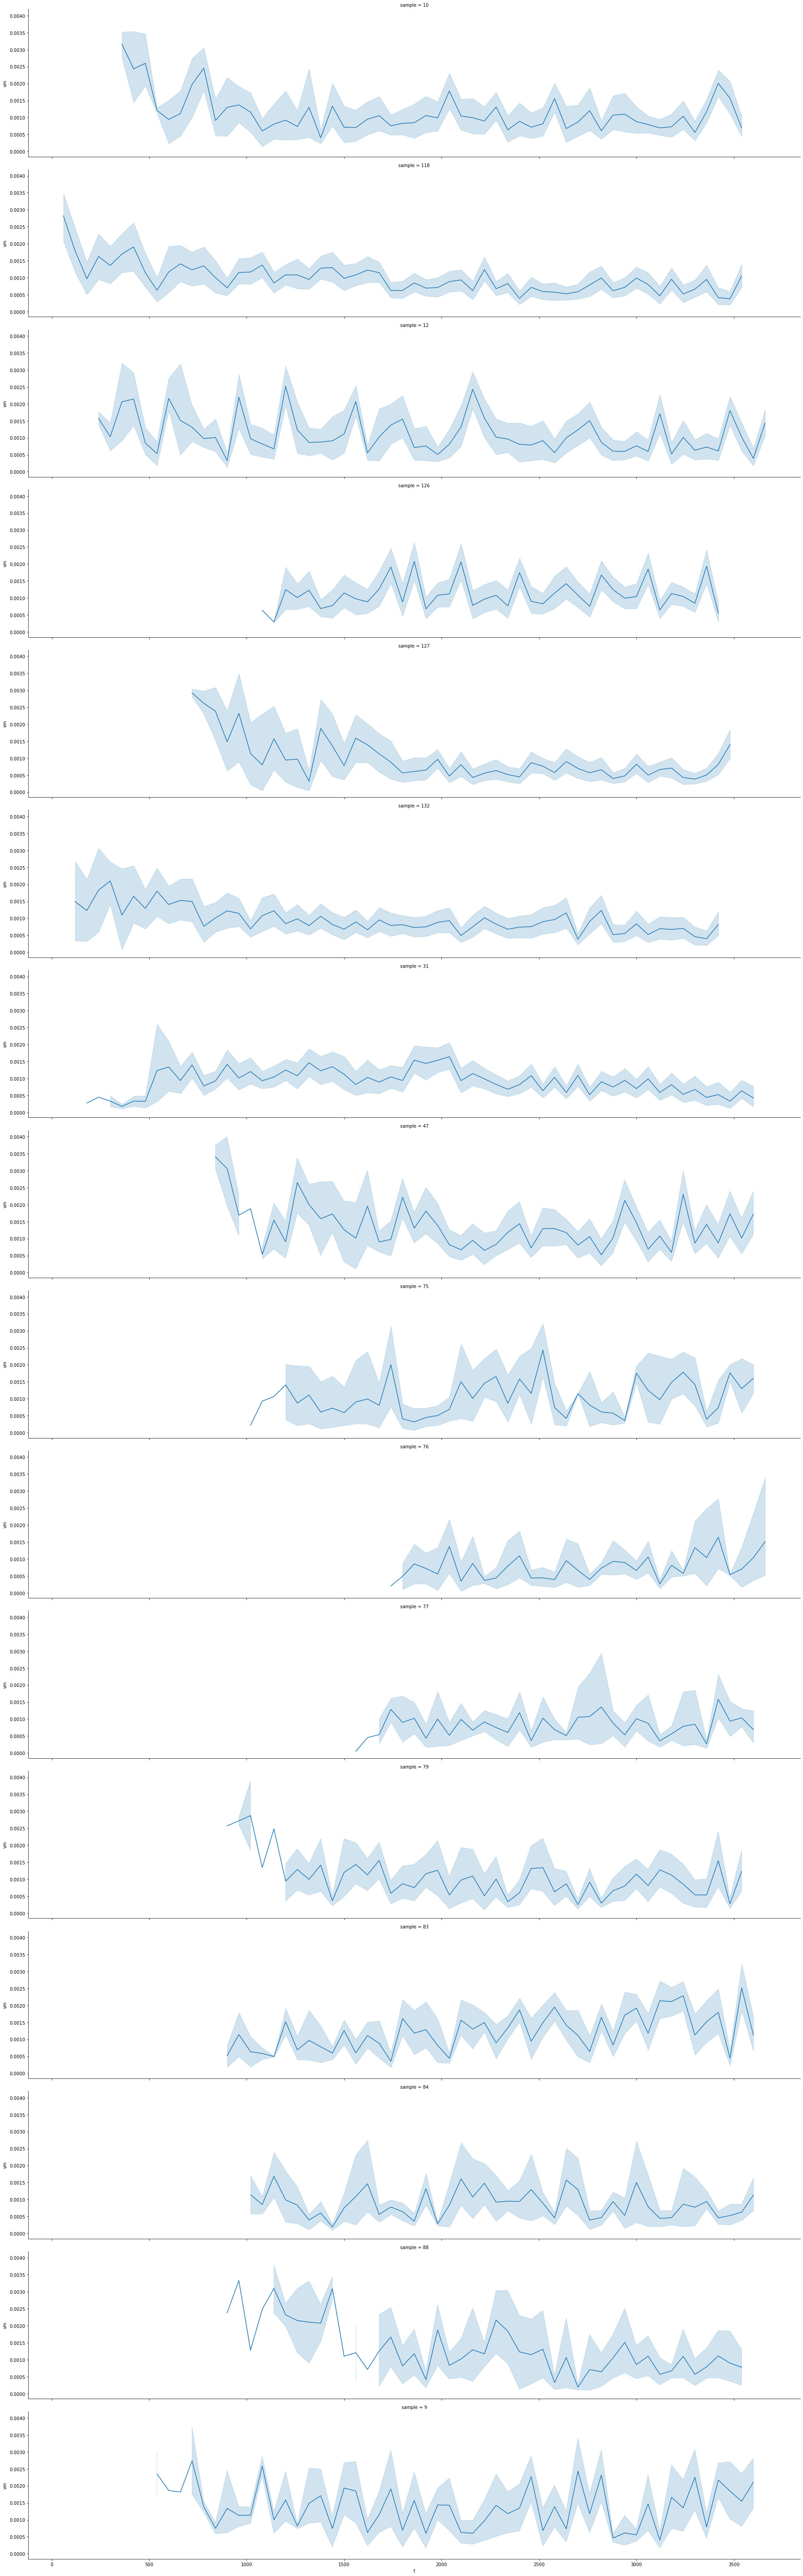

In [9]:
g = sns.FacetGrid(vm, row="sample", aspect=5, height=5)
g.map(sns.lineplot, "t", "vm")

In [11]:
vm = all_data.groupby(['genotype', 'fi']).aggregate({'vm': np.nanmean}).reset_index().dropna()
sns.catplot(data=vm, x='genotype', y='vm', kind='bar')
print(vm)

#animal instead of fi
#boxplot or Swarmplot to maybe find outliers

     genotype    fi        vm
0         HET     1  0.001650
1         HET     2  0.002007
2         HET     3  0.001467
3         HET     4  0.001365
4         HET     5  0.001979
...       ...   ...       ...
3468       WT  2240  0.003312
3469       WT  2241  0.002208
3470       WT  2242  0.001356
3471       WT  2243  0.000109
3472       WT  2244  0.000109

[3448 rows x 3 columns]


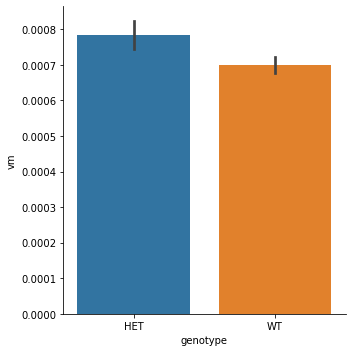

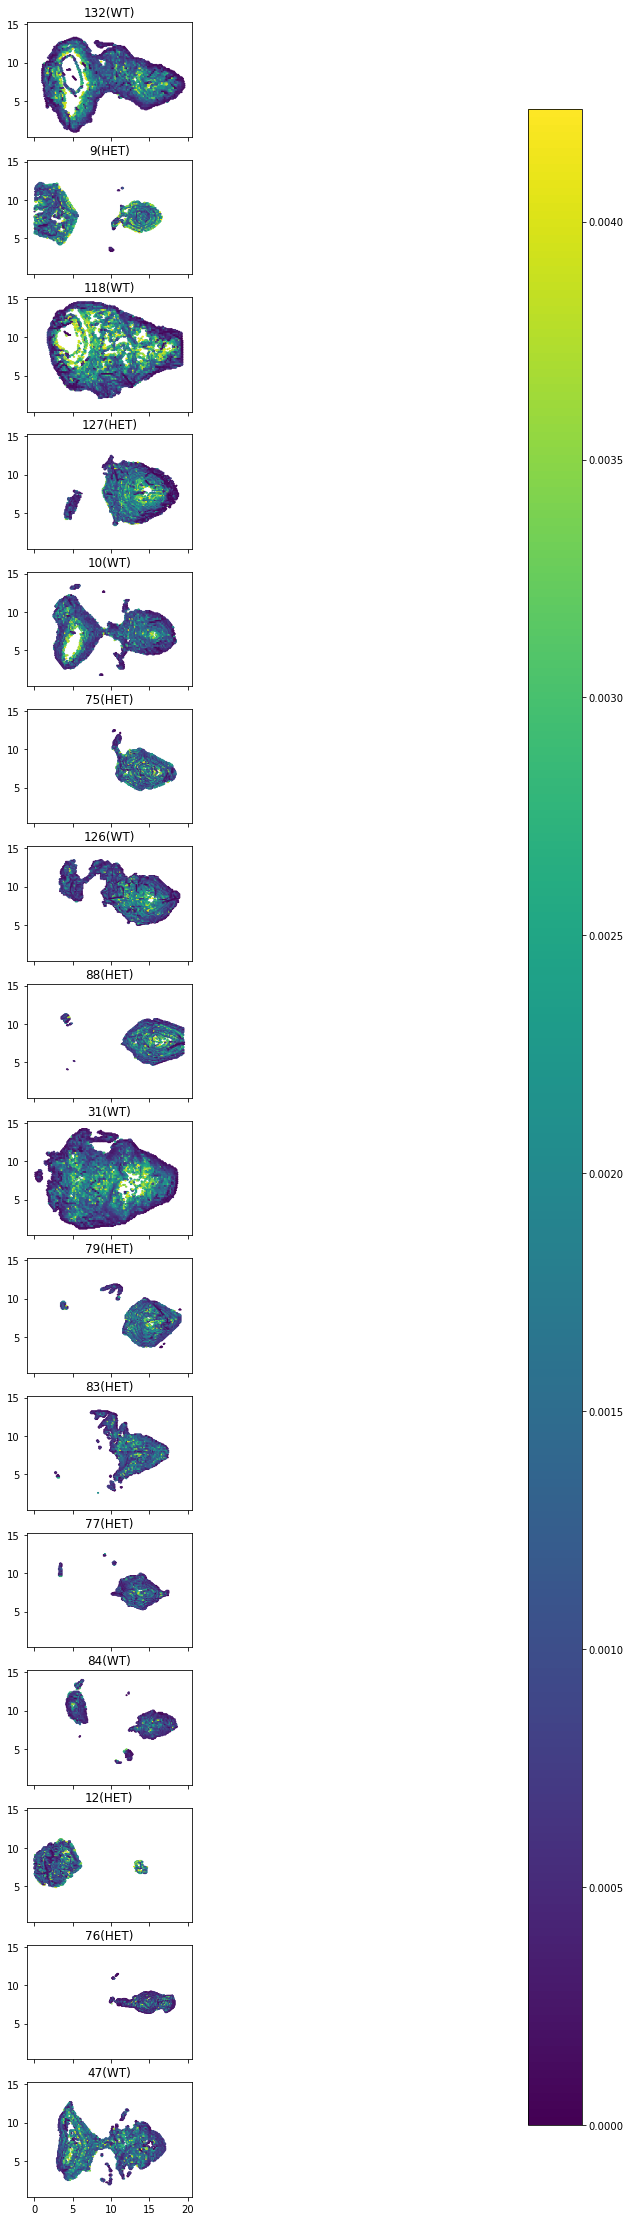

In [12]:
fig, axs = plt.subplots(len(all_data['sample'].unique()), 1, figsize=(15, 40), sharex=True, sharey=True)

vmin = all_data['vm'].min()
vmax = all_data['vm'].max()

for spi, sample in enumerate(all_data['sample'].unique()):
   # for sti, stain in enumerate(['Dextran', 'OVA']):
        subset = all_data[(all_data['sample'] == sample)]
        
        ax = axs[spi]
        ax.set_title('{}({})'.format(sample, get_animal_genotype(sample)))
        im = ax.hexbin(subset['x'], subset['y'], C=subset['vm'], vmin=vmin, vmax=vmax)
        ax.set_aspect('equal')

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax) 

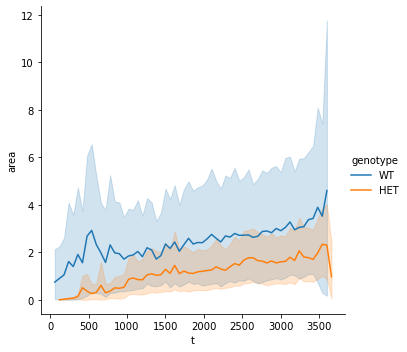

In [13]:
group_cols = ['genotype', 'sample', 't', 'fi']
grouped = all_data.groupby(group_cols)

areas = []
for name, group in grouped:
    data = {}
    for i, gc in enumerate(group_cols):
        data[gc] = name[i]
    
    data['area'] = poly_area(group['x'], group['y'])
    areas.append(data)
    
areas = pd.DataFrame(areas)
sns.relplot(data=areas, x='t', y='area', hue='genotype', kind='line', hue_order=['WT', 'HET'])

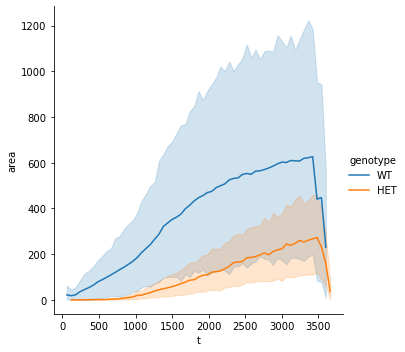

In [14]:
group_cols = ['genotype', 'sample', 't', 'fi']
grouped = all_data.groupby(group_cols)

areas = []
for name, group in grouped:
    data = {}
    for i, gc in enumerate(group_cols):
        data[gc] = name[i]
    
    data['area'] = poly_area(group['x'], group['y'])
    areas.append(data)
    
areas = pd.DataFrame(areas)
sns.relplot(data=areas, x='t', y='area', hue='genotype', kind='line', hue_order=['WT', 'HET'], estimator='sum')

In [31]:
group_cols = ['genotype', 'sample', 't', 'fi']
grouped = all_data.groupby(group_cols)

intensities = []
for name, group in grouped:
    data = {}
    for i, gc in enumerate(group_cols):
        data[gc] = name[i]
    
    print(data['sample'], data['t'])
    scale = read_scale(data['sample'])
    im = load_images(data['sample'], int(data['t'] / 60))
    msk = poly_to_mask(group['x'], group['y'], im.shape, scale)
    
    data['imean'] = np.mean(im[msk])
    data['imed']  = np.median(im[msk])
    data['isum']  = np.sum(im[msk])
    
    intensities.append(data)
    
intensities = pd.DataFrame(intensities)
intensities

12 120
12 120
12 240
12 240
12 300
12 300
12 300
12 300
12 300
12 360
12 360


/var/folders/3n/fcpvb3h559x4r03p9bdnxsy40000gn/T/ipykernel_12343/4153250408.py:55: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
  im = color.rgb2gray(im)


12 360
12 360
12 360
12 420
12 420
12 480
12 480
12 480
12 480
12 540
12 540
12 600
12 600
12 600
12 600
12 660
12 660
12 660
12 660
12 660
12 720
12 720
12 720
12 720
12 780
12 780
12 780
12 780
12 780
12 780
12 780
12 780
12 840
12 840
12 840
12 840
12 840
12 840
12 840
12 840
12 900
12 900
12 900
12 900
12 900
12 900
12 960
12 960
12 960
12 960
12 960
12 960
12 960
12 960
12 1020
12 1020
12 1020
12 1020
12 1020
12 1020
12 1020
12 1080
12 1080
12 1080
12 1080
12 1080
12 1080
12 1080
12 1080
12 1140
12 1140
12 1140
12 1140
12 1140
12 1140
12 1140
12 1140
12 1140
12 1140
12 1200
12 1200
12 1200
12 1200
12 1200
12 1200
12 1200
12 1200
12 1200
12 1200
12 1200
12 1260
12 1260
12 1260
12 1260
12 1260
12 1260
12 1260
12 1320
12 1320
12 1320
12 1320
12 1320
12 1320
12 1320
12 1320
12 1380
12 1380
12 1380
12 1380
12 1380
12 1380
12 1440
12 1440
12 1440
12 1440
12 1440
12 1440
12 1440
12 1440
12 1440
12 1440
12 1440
12 1500
12 1500
12 1500
12 1500
12 1500
12 1500
12 1500
12 1500
12 1500
12 150

/Users/garvitgupta/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/garvitgupta/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


127 1440
127 1440
127 1440
127 1440
127 1440
127 1440
127 1440
127 1500
127 1500
127 1500
127 1500
127 1500
127 1500
127 1500
127 1500
127 1500
127 1500
127 1560
127 1560
127 1560
127 1560
127 1560
127 1560
127 1560
127 1560
127 1560
127 1560
127 1620
127 1620
127 1620
127 1620
127 1620
127 1620
127 1620
127 1620
127 1620
127 1620
127 1620
127 1620
127 1620
127 1680
127 1680
127 1680
127 1680
127 1680
127 1680
127 1680
127 1680
127 1680
127 1680
127 1680
127 1680
127 1680
127 1680
127 1680
127 1680
127 1740
127 1740
127 1740
127 1740
127 1740
127 1740
127 1740
127 1740
127 1740
127 1740
127 1740
127 1740
127 1740
127 1740
127 1740
127 1740
127 1740
127 1740
127 1800
127 1800
127 1800
127 1800
127 1800
127 1800
127 1800
127 1800
127 1800
127 1800
127 1800
127 1800
127 1800
127 1800
127 1800
127 1800
127 1800
127 1800
127 1800
127 1860
127 1860
127 1860
127 1860
127 1860
127 1860
127 1860
127 1860
127 1860
127 1860
127 1860
127 1860
127 1860
127 1860
127 1860
127 1860
127 1860
127 1860
1

,genotype,sample,t,fi,imean,imed,isum
0,HET,12,120,1,14.344828,13.0,416
1,HET,12,120,2,14.200000,13.0,497
2,HET,12,240,3,16.952381,17.0,14240
3,HET,12,240,4,16.434783,17.0,2268
4,HET,12,300,5,18.047354,20.0,19437
...,...,...,...,...,...,...,...
12773,WT,84,3600,249,16.489209,17.0,6876
12774,WT,84,3600,250,29.633002,26.0,3801203
12775,WT,84,3600,251,18.773438,19.0,2403
12776,WT,84,3600,252,15.018182,15.0,826


In [32]:
pd.melt(intensities, id_vars=['genotype', 'sample', 't', 'fi'], value_vars=['imean', 'imed', 'isum'], var_name='measure', value_name='intensity')

,genotype,sample,t,fi,measure,intensity
0,HET,12,120,1,imean,1.434483e+01
1,HET,12,120,2,imean,1.420000e+01
2,HET,12,240,3,imean,1.695238e+01
3,HET,12,240,4,imean,1.643478e+01
4,HET,12,300,5,imean,1.804735e+01
...,...,...,...,...,...,...
38329,WT,84,3600,249,isum,6.876000e+03
38330,WT,84,3600,250,isum,3.801203e+06
38331,WT,84,3600,251,isum,2.403000e+03
38332,WT,84,3600,252,isum,8.260000e+02


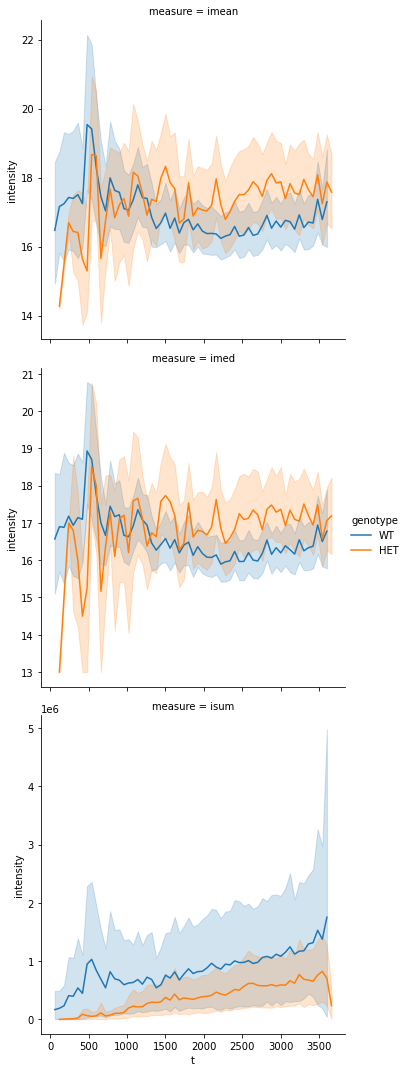

In [34]:
mi = pd.melt(intensities, id_vars=['genotype', 'sample', 't', 'fi'], value_vars=['imean', 'imed', 'isum'], var_name='measure', value_name='intensity')
mi = mi[mi['intensity'] > 0]
sns.relplot(data=mi, x='t', y='intensity',  row='measure', hue='genotype', kind='line', hue_order=['WT', 'HET'], facet_kws={'sharey': False, 'sharex': True})

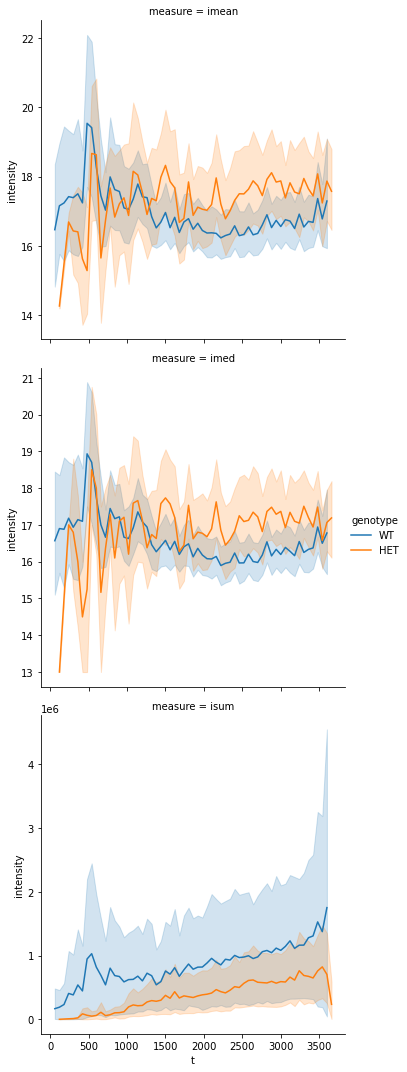

In [35]:
exclude = ['4.14.21 Injection 2', '4.16.21 Injection 1', '4.16.21 Injection 2']
mi = pd.melt(intensities[~intensities['sample'].isin(exclude)], 
             id_vars=['genotype', 'sample', 't', 'fi'], 
             value_vars=['imean', 'imed', 'isum'], 
             var_name='measure',
             value_name='intensity')

sns.relplot(data=mi, x='t', y='intensity', row='measure', hue='genotype', kind='line', hue_order=['WT', 'HET'], facet_kws={'sharey': False, 'sharex': True})

12 120
416 753891 416


,genotype,sample,t,fi,imean,imed,isum
0,HET,12,120,1,14.344828,13.0,416
1,HET,12,120,2,14.200000,13.0,497
2,HET,12,240,3,16.952381,17.0,14240
3,HET,12,240,4,16.434783,17.0,2268
4,HET,12,300,5,18.047354,20.0,19437
...,...,...,...,...,...,...,...
12773,WT,84,3600,249,16.489209,17.0,6876
12774,WT,84,3600,250,29.633002,26.0,3801203
12775,WT,84,3600,251,18.773438,19.0,2403
12776,WT,84,3600,252,15.018182,15.0,826


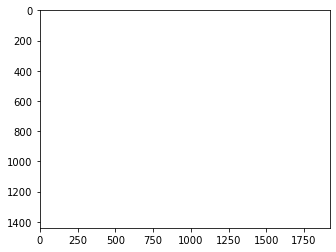

In [36]:
group_cols = ['genotype', 'sample', 't', 'fi']
grouped = all_data.groupby(group_cols)

for name, group in grouped:
    data = {}
    for i, gc in enumerate(group_cols):
        data[gc] = name[i]
    
    print(data['sample'], data['t'])
    scale = read_scale(data['sample'])
    im = load_images(data['sample'], int(data['t'] / 60))
    msk = poly_to_mask(group['x'], group['y'], im.shape, scale)
    #print(group['x'].values, group['y'].values, np.swapaxes(np.array([group['x'].values, group['y'].values]), 0, 1))
    
    plt.imshow(np.ma.masked_where(~msk, im))
    print(np.sum(im[msk]), np.sum(im[~msk]), np.sum(np.ma.masked_where(~msk, im)))
    break
    
    
    intensities.append(data)
    
intensities = pd.DataFrame(intensities)
intensities

In [37]:
samples = all_data['sample'].unique()
#stains = all_data['stain'].unique()

whole_img_intensities = []
for sample in samples:
#    for stain in stains:
        genotype = get_animal_genotype(sample)
        imgs = load_images(sample)
        
        means = np.mean(imgs, axis=(1,2))
        medians = np.median(imgs, axis=(1,2))
        sums = np.sum(imgs, axis=(1,2))
        
        for i in range(imgs.shape[0]):
            whole_img_intensities.append({
                'sample': sample,
                #'stain': stain,
                'genotype': genotype,
                't': i * 60,
                'mean': means[i],
                'median': medians[i],
                'sum': sums[i]
            })

whole_img_intensities = pd.DataFrame(whole_img_intensities)

/var/folders/3n/fcpvb3h559x4r03p9bdnxsy40000gn/T/ipykernel_12343/4153250408.py:55: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
  im = color.rgb2gray(im)


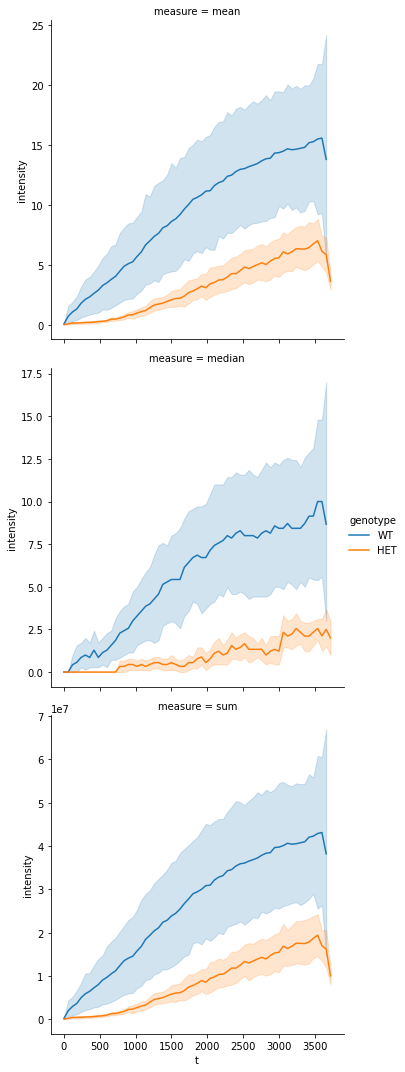

In [38]:
wii_melt = pd.melt(whole_img_intensities, id_vars=['genotype', 'sample', 't'], value_vars=['mean', 'median', 'sum'], var_name='measure', value_name='intensity')
sns.relplot(data=wii_melt, x='t', y='intensity',  row='measure', hue='genotype', kind='line', hue_order=['WT', 'HET'], facet_kws={'sharey': False, 'sharex': True})

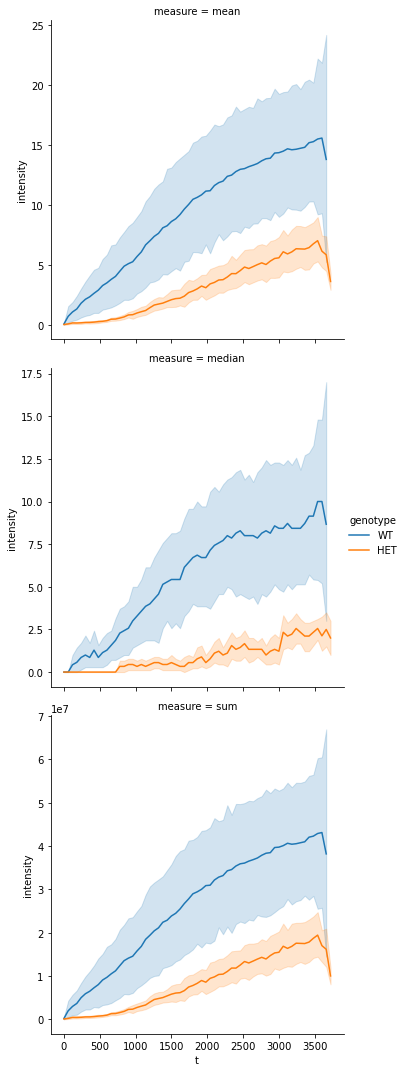

In [39]:
exclude = ['4.14.21 Injection 2', '4.16.21 Injection 1', '4.16.21 Injection 2']
wii_melt = pd.melt(whole_img_intensities[~whole_img_intensities['sample'].isin(exclude)],
                   id_vars=['genotype', 'sample', 't'],
                   value_vars=['mean', 'median', 'sum'],
                   var_name='measure',
                   value_name='intensity')

sns.relplot(data=wii_melt, x='t', y='intensity', row='measure', hue='genotype', kind='line', hue_order=['WT', 'HET'], facet_kws={'sharey': False, 'sharex': True})

   genotype sample        vm
0       HET     12  0.000743
1       HET    127  0.000658
2       HET     75  0.001044
3       HET     76  0.000704
4       HET     77  0.000819
5       HET     79  0.000921
6       HET     83  0.001029
7       HET     88  0.001009
8       HET      9  0.001258
9        WT     10  0.000771
10       WT    118  0.000611
11       WT    126  0.000766
12       WT    132  0.000636
13       WT     31  0.000685
14       WT     47  0.001069
15       WT     84  0.000637


<AxesSubplot:xlabel='genotype', ylabel='vm'>

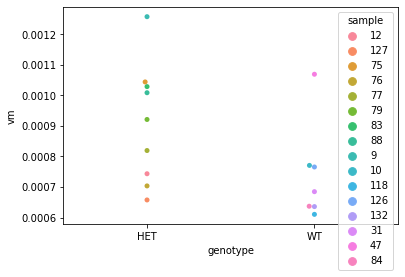

In [40]:
vm = all_data.groupby(['genotype', 'sample']).aggregate({'vm': np.nanmean}).reset_index().dropna()
#sns.catplot(data=vm, x='genotype', y='vm', kind='bar')
print(vm)

sns.swarmplot(data=vm, x="genotype", y="vm", hue="sample")


#animal instead of fi
#boxplot or Swarmplot to maybe find outliers